# Pixel classification for gully detection using deep learning

## Table of Contents

* [Introduction](#1)
* [Data preparation](#19)


* [Model training](#7)
    * [Necessary Imports](#6) 
    * [Get training data](#8)
    * [Visualize training data](#9)
    * [Load model architecture](#10)
    * [Train the model](#11)
    * [Visualize classification results in validation set](#12)
    * [Evaluate model performance](#13) 
    * [Save model](#14)

### Export training data for deep learning model<a class="anchor" id="5"></a>

The dataset was prepared in ArcGIS Pro

The [Export training data for deep learning](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool is used to prepare training data for training a deep learning model. The tool is available in both `ArcGIS Pro` and `ArcGIS Enterprise`.
See here an example

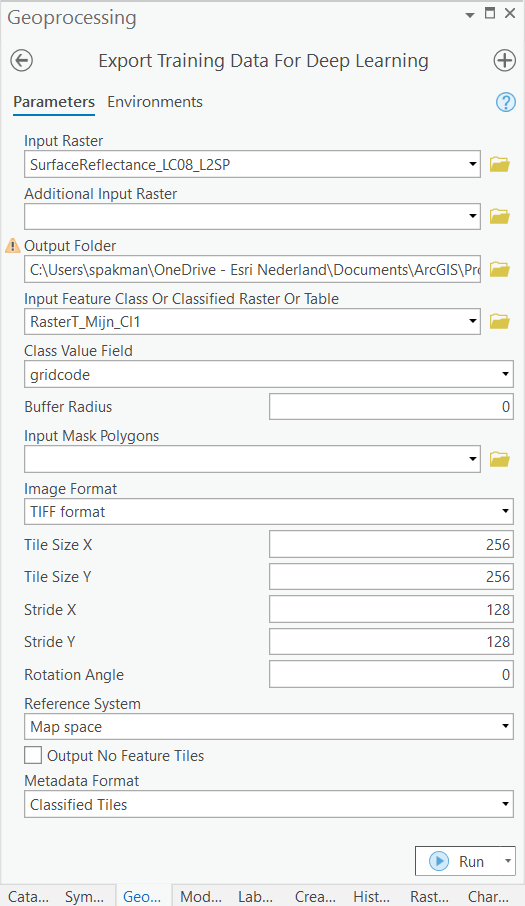

## Import libraries

In [1]:
import os
import arcpy
from arcpy import env

from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt
import arcgis
from arcgis.learn import prepare_data, UnetClassifier
#%matplotlib inline

## Path to ArcGIS Pro, work folders, workgdb etc

In [2]:
mainpath=r'C:\DATA\...'
maingdb= r'C:\DATA\...\.... .gdb'

In [3]:
env.workspace= r'C:\DATA\...'
# Define project path
p = arcpy.mp.ArcGISProject(r"C:\DATA\...\... .aprx")
m = p.listMaps("...")[0]


#### List the layers i your map

In [4]:
for lyr in m.listLayers():
    print("Layer name: " + lyr.name)

Layer name: TrainingData_ravine
Layer name: CB3_Oslo_Slope_TPI_SD
Layer name: CB3_Oslo_Slope_TPI_SD2
Layer name: CB3_Trond3_Slope_TPI_SD
Layer name: CB3_Trond2_Slope_TPI_SD
Layer name: CB3_Nes_Slope_TPI_SD
Layer name: CB3_Byneset_Slope_TPI_SD
Layer name: CB3_Nes_Slope_TPI_SD
Layer name: GeocacheBasis


In [5]:
# Define the map extent

fc = os.path.join(maingdb, '...')
desc= arcpy.Describe(fc)
xmin = desc.extent.XMin
xmax = desc.extent.XMax
ymin = desc.extent.YMin
ymax = desc.extent.YMax

# Set the extent environment using the Extent class.
print(xmin, ymin, xmax, ymax)


266839.1776999999 6642922.6545 310796.6217 6686167.661


In [6]:
# Set extend
arcpy.env.extent =arcpy.Extent( xmin, ymin, xmax, ymax)

## Model training<a class="anchor" id="7"></a>

This step will utilize Jupyter Notebooks, and documentation on how to install and setup the environment is available [here](https://developers.arcgis.com/python/guide/install-and-set-up/). 

### Get training data<a class="anchor" id="8"></a>

We have already exported the data, and it can be directly downloaded using the following steps (define the folder where your exported data er located):

In [7]:
data_path = r"C:\DATA\Training\..."

### Visualize training data<a class="anchor" id="9"></a>

The `prepare_data` function takes a training data path as input and creates a fast.ai databunch with specified transformation, batch size, split percentage, etc.

In [8]:
data = prepare_data(data_path,  
                    batch_size=2)

To get a sense of what the training data looks like, use the `show_batch()` method to randomly pick a few training chips and visualize them. The chips are overlaid with masks representing the building footprints in each image chip.

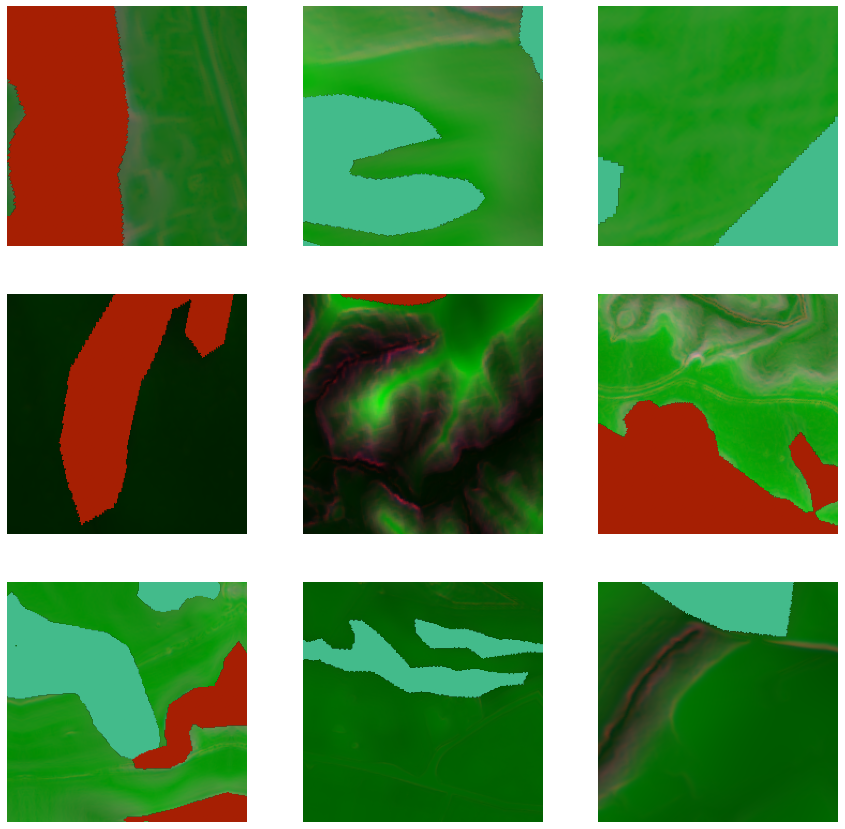

In [9]:
data.show_batch(alpha=1)
plt.show()

### Load model architecture<a class="anchor" id="10"></a>

`arcgis.learn` provides the UnetClassifier model for per pixel classification that is based on a pretrained convnet, like ResNet, that acts as the 'backbone'. More details about UnetClassifier can be found [here](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#unetclassifier).

In [10]:
model = UnetClassifier(data, pointrend=True)

### Train the model<a class="anchor" id="11"></a>


Learning rate is one of the most important hyperparameters in model training. We will use the `lr_find()` method to find an optimum learning rate at which we can train a robust model.

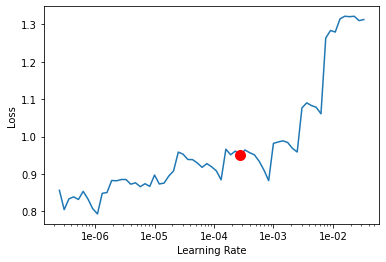

In [11]:
lr = model.lr_find()

In the original Esri example there are hyperspectral image data used and the suggested epocs is 2000. We will use early stopping optimiser. 

In [ ]:
model.fit(epochs=50, lr=lr,  early_stopping=True, checkpoint=True, tensorboard=True, monitor='valid_loss')


Monitor training on Tensorboard using the following command: 'tensorboard --host=D2112-JARALE --logdir="C:\DATA\Kvikkleire ravine\Training\Training_CB3_Nesonly_3\training_log"'


epoch,train_loss,valid_loss,accuracy,dice,time
0,0.531418,0.486919,0.778163,0.410590,39:47
1,0.454888,0.413703,0.810448,0.444032,38:45
2,0.475121,0.434759,0.808202,0.534063,39:02
3,0.461986,0.382800,0.835272,0.547648,42:28
4,0.397761,0.374492,0.838686,0.487923,46:47
5,0.394101,0.363388,0.845780,0.518003,53:46
6,0.424769,0.397095,0.831569,0.550799,53:24
7,0.374993,4.058199,0.827406,0.461294,53:19


Exception in thread Thread-16:
Traceback (most recent call last):
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tensorboard\summary\writer\event_file_writer.py", line 234, in run
    self._record_writer.write(data)
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tensorboard\summary\writer\record_writer.py", line 40, in write
    self._writer.write(header + header_crc + data + footer_crc)
  File "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\tensorflow\python\lib\io\file_io.py", line 103, in write
    self._writable_file.append(compat.as_bytes(file_content))
tensorflow.python.framework.errors_impl.UnknownError: Failed to WriteFile: C:\DATA\Kvikkleire ravine\Training\Training_CB3_Nesonly_3\training_log\UnetClassifier_log_2023-06-06_12-23-19-Epoch-8\events.ou

### Visualize classification results in validation set<a class="anchor" id="12"></a>

It's a good practice to see results of the model vis-a-vis ground truth. The code below picks random samples and shows us ground truths and model predictions, side by side. This enables us to preview the results of the model within the notebook.

In [ ]:
model.show_results()

Check the performance of teh model you just have saved

### Evaluate model performance<a class="anchor" id="13"></a>

As we have 7 classes for this segmentation task, we need to perform an accuracy assessment for each class. To achieve this, ArcGIS API for Python provides the per_class_metrics function that calculates a precision, recall, and f1 score for each class.

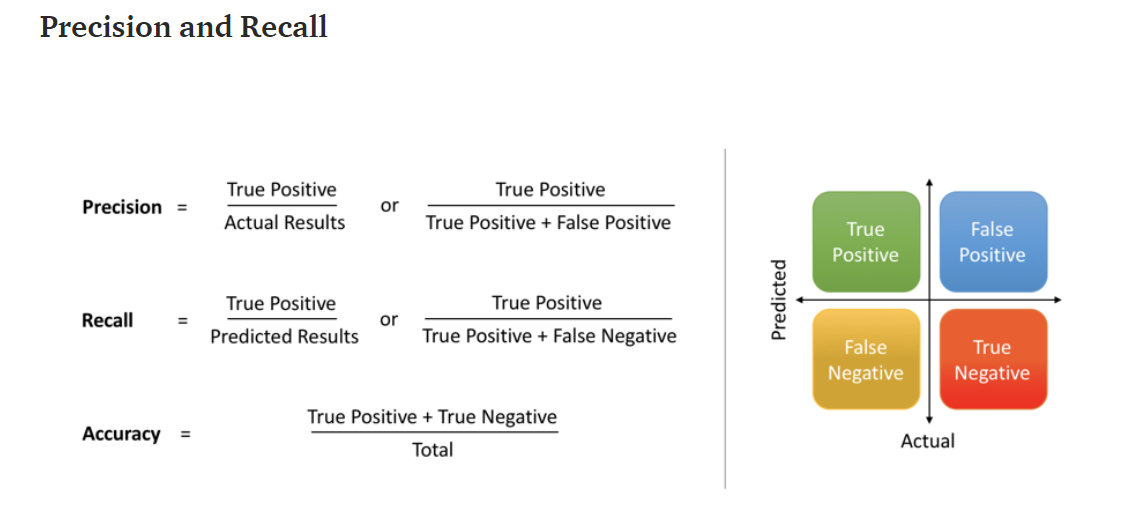

In [ ]:
model.per_class_metrics()

### Save model<a class="anchor" id="14"></a>

We will save the model that we trained as a 'Deep Learning Package' ('.dlpk' format). A Deep Learning Package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
mainpad= r'C:\DATA\...'

In [ ]:
# model.save('unet_2000e', publish=True, gis=gis)
model.save(os.path.join(mainpad, 'unet_2000e'))

Go to the location of your saved model and look at the results. If you need o train furter just continue with:
    

In [ ]:
model.unfreeze()
model.fit(epochs=30, lr=lr, early_stopping=True, checkpoint=True,
tensorboard=True)


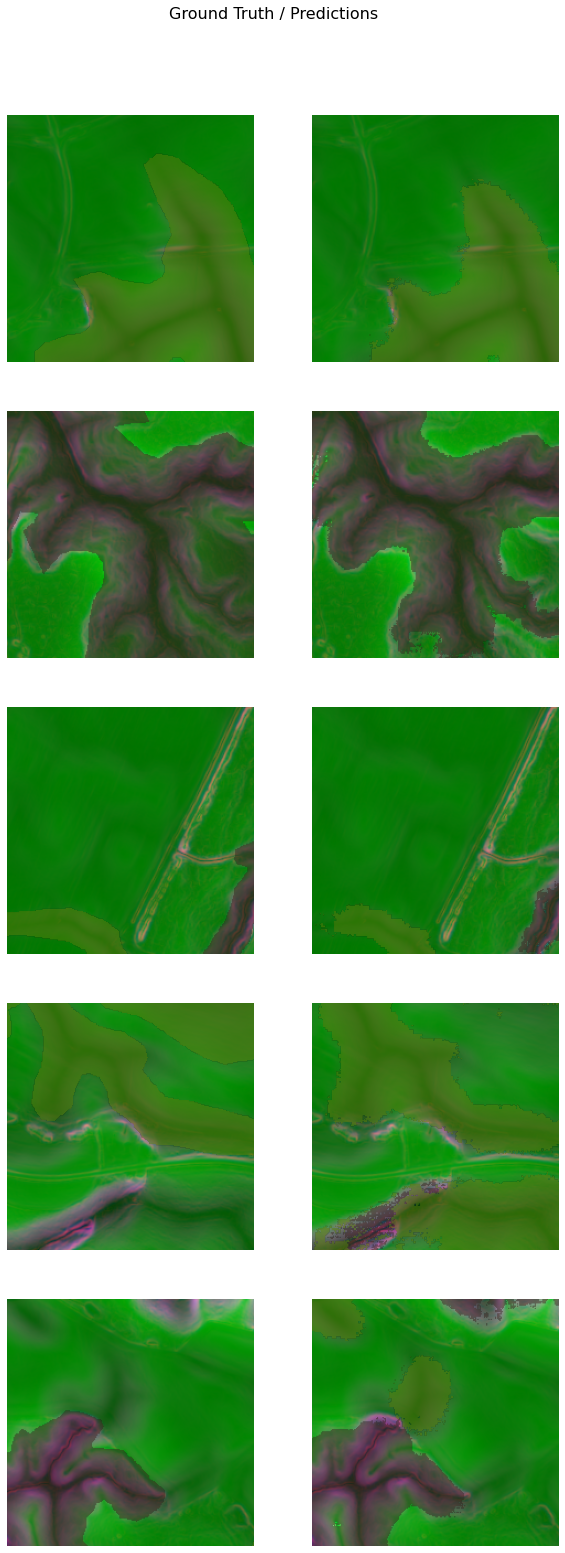

In [24]:
model.show_results()

## Model inference<a class="anchor" id="15"></a>


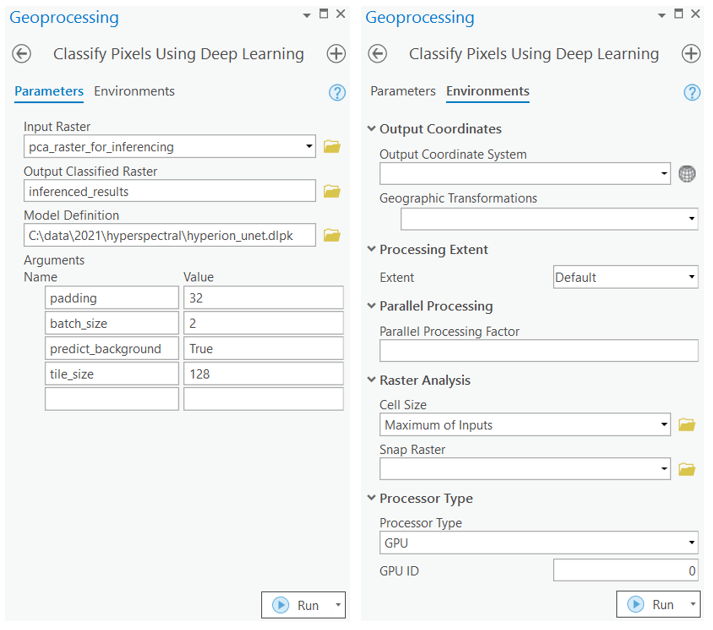